In [2]:
# 导入必要的库
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import d2l.torch as d2l
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
# 设置matplotlib显示配置
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
def use_svg_display():
    """设置matplotlib输出为SVG格式"""
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5), fontsize=10):
    """设置图表大小和字体大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['font.size'] = fontsize

# 定义变量保存和加载函数
def save_variable(v, filename):
    """将变量保存到文件"""
    f = open(filename, 'wb')
    pickle.dump(v, f)
    f.close()
    return filename

def load_variable(filename):
    """从文件加载变量"""
    f = open(filename, 'rb')
    r = pickle.load(f)
    f.close()
    return r

In [4]:
import time
class Timer:
    'Record multiple running times.'
    def __init__(self):
        self.times = []
        self.start()
 
    def start(self):
       self.tik = time.time()
 
    def stop(self):
       self.times.append(time.time() - self.tik)
       return self.times[-1]
 
    def avg(self):
        return sum(self.times) / len(self.times)
 
    def sum(self):
        return sum(self.times)
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
class Accumulator:
    'For accumulating sums over `n` variables.'
    def __init__(self, n):
        self.data = [0.0] * n
 
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
 
    def reset(self):
        self.data = [0.0] * len(self.data)
 
    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
def try_gpu(i=0):
    'Return gpu(i) if exists, otherwise return cpu().'
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

## 简单的回归模型实验

In [6]:
import tqdm
def train(net, train_iter, num_epochs, lr, device, test_iter=None):
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    timer, num_batches = Timer(), len(train_iter)
    train_ls, test_ls = [], []
    # train_accs, test_accs = [], []
    bar = tqdm.tqdm(total = num_epochs)
    for epoch in range(num_epochs):
        metric = Accumulator(2)  
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[1]
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                # print(f'{i}, train_loss: {train_l}')
                train_ls.append(train_l)
        if train_ls[-1] < 1e-10:
            break
        net.eval()
        metric2 = Accumulator(2)
        if test_iter != None:
            with torch.no_grad():
                for (X_test,y_test) in test_iter:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    y_hat = net(X_test)
                    l = loss(y_hat, y_test)
                    metric2.add(l * X_test.shape[0], X_test.shape[0])
                test_l = metric2[0] / metric2[1]
                test_ls.append(test_l)
        bar.set_description('Epoch:')
        bar.update(1)
    if test_iter != None:
        print(f'train loss {train_l:.3f}', 
                f'test loss {test_l:.3f}')
    else:
        print(f'train loss {train_l:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return train_ls, test_ls

In [7]:
# 定义目标函数
def f_star(x, a=1.0, b=0.0):
    y = 1 + a * x[:, 0] + b * x[:, 1]
    return y

def generate_data(a, b, num_samples):
    # x = torch.randn(num_samples, 2)
    # [-1, 1] uniform distribution
    x = 2 * torch.rand(num_samples, 2) - 1
    y = f_star(x, a, b)
    return x, y

sample_size = 2
x_train, y_train = generate_data(1.0, 0.0, sample_size)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)

test_size = 1000
x_test, y_test = generate_data(1.0, 0.0, test_size)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [8]:
# 线性模型
num_inputs, num_outputs, num_hiddens = 2, 1, 1
loss = nn.MSELoss()
sigma = 1e-12 # 初始化参数的标准差
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.theta0 = torch.nn.Parameter(torch.randn(1) * sigma)
        self.theta1 = torch.nn.Parameter(torch.randn(1) * sigma)
        self.theta2 = torch.nn.Parameter(torch.randn(1) * sigma)

    def forward(self, x):
        return self.theta0 + self.theta1 * x[:, 0] + self.theta2 * x[:, 1]

batch_size, num_epochs, lr = 1024, 10000, 1e-1
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)
train_ls_dict = {}
test_ls_dict = {}
for sample_size in range(1, 4):
    net = LinearModel()
    x_train, y_train = generate_data(1.0, 0.0, sample_size)
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    train_ls_dict[sample_size], test_ls_dict[sample_size] = train(net, train_iter, num_epochs, lr, try_gpu(), test_iter=test_iter)

training on cpu


Epoch::   0%|          | 36/10000 [00:00<01:44, 95.37it/s]


train loss 0.000 test loss 0.464
79709.2 examples/sec on cpu
training on cpu


Epoch::   1%|          | 111/10000 [00:00<01:10, 141.09it/s]


train loss 0.000 test loss 0.259
293860.8 examples/sec on cpu
training on cpu


Epoch::  10%|▉         | 960/10000 [00:07<01:06, 135.24it/s]

train loss 0.000 test loss 0.000
49155.1 examples/sec on cpu


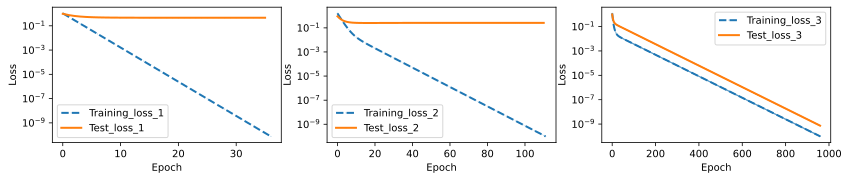

In [9]:
set_figsize((3.5 * 4, 2.5))

for sample_size in range(1, 4):
    plt.subplot(1, 3, sample_size)
    plt.plot(train_ls_dict[sample_size], 'o--', markersize=0.1, linewidth=2, label=f'Training_loss_{sample_size}')
    plt.plot(test_ls_dict[sample_size], 'o-', markersize=0.1, linewidth=2, label=f'Test_loss_{sample_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
plt.savefig('overfitting.pdf', bbox_inches='tight')
plt.show()

In [11]:
# 线性模型
num_inputs, num_outputs, num_hiddens = 2, 1, 1
loss = nn.MSELoss()
sigma = 1e-12 # 初始化参数的标准差
class NonLinearModel(torch.nn.Module):
    def __init__(self):
        super(NonLinearModel, self).__init__()
        self.theta0 = torch.nn.Parameter(torch.randn(1) * sigma)
        self.theta1 = torch.nn.Parameter(torch.randn(1) * sigma)
        self.theta2 = torch.nn.Parameter(torch.randn(1) * sigma)
        self.theta3 = torch.nn.Parameter(torch.randn(1) * sigma)
        

    def forward(self, x):
        return self.theta0 + self.theta1 * x[:, 0] + self.theta2 * self.theta3 * x[:, 1]

batch_size, num_epochs, lr = 1024, 10000, 1e-1
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)
train_ls_dict_NL = {}
test_ls_dict_NL = {}
for sample_size in range(1, 4):
    net = NonLinearModel()
    x_train, y_train = generate_data(1.0, 0.0, sample_size)
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    train_ls_dict_NL[sample_size], test_ls_dict_NL[sample_size] = train(net, train_iter, num_epochs, lr, try_gpu(), test_iter=test_iter)

training on cpu


Epoch::   0%|          | 44/10000 [00:00<01:29, 110.68it/s]


train loss 0.000 test loss 0.115
193487.4 examples/sec on cpu
training on cpu


Epoch::   1%|          | 93/10000 [00:00<01:13, 134.63it/s]


train loss 0.000 test loss 0.000
339198.2 examples/sec on cpu
training on cpu


Epoch::   3%|▎         | 303/10000 [00:02<01:10, 137.09it/s]

train loss 0.000 test loss 0.000
147742.8 examples/sec on cpu


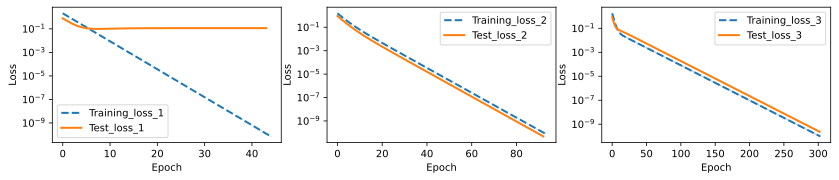

In [12]:
set_figsize((3.5 * 4, 2.5))

for sample_size in range(1, 4):
    plt.subplot(1, 3, sample_size)
    plt.plot(train_ls_dict_NL[sample_size], 'o--', markersize=0.1, linewidth=2, label=f'Training_loss_{sample_size}')
    plt.plot(test_ls_dict_NL[sample_size], 'o-', markersize=0.1, linewidth=2, label=f'Test_loss_{sample_size}')
    plt.xlabel('Epoch'):
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
plt.savefig('overfitting2.pdf', bbox_inches='tight')
plt.show()

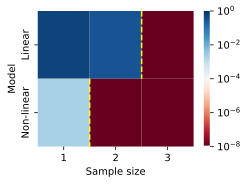

In [24]:
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
set_figsize((3.5, 2.5))

sns.heatmap(np.array([[test_ls_dict[1][-1], test_ls_dict[2][-1], test_ls_dict[3][-1]], [test_ls_dict_NL[1][-1], test_ls_dict_NL[2][-1], test_ls_dict_NL[3][-1]]]), cmap='RdBu', annot=False, norm=LogNorm(vmax=1e0, vmin=1e-8))
plt.vlines(1, 1, 2, colors='yellow', linestyles='dashed')
plt.vlines(2, 0, 1, colors='yellow', linestyles='dashed')

plt.xlabel('Sample size')
plt.ylabel('Model')
plt.xticks([0.5, 1.5, 2.5], ['1', '2', '3'])
plt.yticks([0.5, 1.5], ['Linear', 'Non-linear'])
plt.savefig('LM_optimistic.pdf', bbox_inches='tight')
plt.show()

## 矩阵分解模型实验

In [25]:
M1 = torch.tensor([[4, 0.6, 1.8, 0.8], [8, 1.2, 3.6, 1.6], [8, 1.2, 3.6, 1.6], [6, 0.9, 2.7, 1.2]])
print(np.linalg.matrix_rank(M1))
M2 = torch.tensor([[4, 0.6, 1.8, 0.8], [10, 2.7, 5.1, 3.6], [8, 1.2, 3.6, 1.6], [6, 0.9, 2.7, 1.2]])
print(np.linalg.matrix_rank(M2))
M3 = torch.tensor([[4, 0.6, 1.8, 0.8], [8, 2.7, 5.1, 3.6], [8, 2.2, 2.6, 1.6], [6, 0.9, 2.7, 1.2]])
print(np.linalg.matrix_rank(M3))
def mod(ls, d):
    ls_index = []
    for item in ls:
        i = item // d
        j = item % d
        ls_index.append((i, j))
    return ls_index
sample_patterns = [
    [0],
    [0, 1],
    [0, 1, 2],
    [0, 1, 2, 3],
    [0, 1, 2, 3, 4],
    [0, 1, 2, 3, 4, 8],
    [0, 1, 2, 3, 4, 8, 12], # 7
    [0, 1, 2, 3, 4, 8, 12, 5],
    [0, 1, 2, 3, 4, 8, 12, 5, 6],
    [0, 1, 2, 3, 4, 8, 12, 5, 6, 7],
    [0, 1, 2, 3, 4, 8, 12, 5, 6, 7, 9],
    [0, 1, 2, 3, 4, 8, 12, 5, 6, 7, 9, 13], # 12
    [0, 1, 2, 3, 4, 8, 12, 5, 6, 7, 9, 13, 10],
    [0, 1, 2, 3, 4, 8, 12, 5, 6, 7, 9, 13, 10, 11],
    [0, 1, 2, 3, 4, 8, 12, 5, 6, 7, 9, 13, 10, 11, 14], # 15
    [0, 1, 2, 3, 4, 8, 12, 5, 6, 7, 9, 13, 10, 11, 14, 15], # 16
]
def fix_sample(M, ls, d=4):
    M_vec = M.reshape(-1, )
    size = M_vec.shape
    train_features = mod(ls, d)
    train_labels = M_vec[ls]
    return torch.tensor(train_features), train_labels.reshape(-1, 1)

1
2
3


In [26]:
import tqdm
# import string_method_new as smn
def train(net, train_iter, num_epochs, lr, device, test_iter=None):
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    timer, num_batches = Timer(), len(train_iter)
    train_ls, test_ls = [], []
    # train_accs, test_accs = [], []
    # bar = tqdm.tqdm(total = num_epochs)
    # params_training = torch.zeros(num_epochs, len(smn.convert(net.parameters())))
    # for epoch in tqdm.tqdm(range(num_epochs)):
    for epoch in range(num_epochs):
        metric = Accumulator(2)  
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            optimizer.step()
            # params_training[epoch] = smn.convert(net.parameters())
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[1]
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                # print(f'{i}, train_loss: {train_l}')
                train_ls.append(train_l)
        if train_l < 1e-8:
            break
        net.eval()
        metric2 = Accumulator(2)
        if test_iter != None:
            with torch.no_grad():
                for (X_test,y_test) in test_iter:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    y_hat = net(X_test)
                    l = loss(y_hat[0], y_test)
                    metric2.add(l * X_test.shape[0], X_test.shape[0])
                test_l = metric2[0] / metric2[1]
                test_ls.append(test_l)
        # bar.set_description('Epoch:')
        # bar.update(1)
    if test_iter != None:
        print(f'train loss {train_l:.3f}', 
                f'test loss {test_l:.3f}')
    else:
        print(f'train loss {train_l:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return train_ls, test_ls

In [27]:
d = 4
num_inputs, num_outputs, num_hiddens = d, d, d
loss = nn.MSELoss()
class MatrixFactorization(nn.Module):
    def __init__(self):
        super(MatrixFactorization, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens, bias=False),
            nn.Linear(num_hiddens, num_outputs, bias=False)
        )
    def forward(self, x):
        y = self.linear_stack(torch.eye(d, d))
        return y[x.T.numpy().tolist()].reshape(-1, 1), y
net = MatrixFactorization()

In [28]:
outputs_sample_ls = {}
theta_A_sample_ls = {}
theta_B_sample_ls = {}
batch_size, num_epochs, lr = 1024, 100000, 1e-1
M = M1
test_ls_M1 = {}
for i, ls in enumerate(sample_patterns):
    features_train, labels_train = fix_sample(M, ls=ls)
    train_dataset = torch.utils.data.TensorDataset(features_train, labels_train)
    def init_weights(m, sigma=1e-7):
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                # nn.init.xavier_uniform_(m.weight)
                nn.init.normal_(m.weight, 0, sigma)
                if m.bias:
                    nn.init.normal_(m.bias, 0, sigma)
    net.apply(init_weights)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    train_ls, test_ls = train(net, train_iter, num_epochs, lr, try_gpu())
    AB = net(features_train)[1].detach().clone()
    A = np.copy(list(net.parameters())[0].detach().T)
    theta_A_sample_ls[i+1]=(A)
    B = np.copy(list(net.parameters())[1].detach().T)
    theta_B_sample_ls[i+1]=(B)
    outputs_sample_ls[i+1]=(AB)
    # frobenius norm
    test_ls_M1[i+1] = np.linalg.norm(AB - M1.numpy(), ord='fro') / d ** 2

training on cpu
train loss 0.000
5314896.9 examples/sec on cpu
training on cpu
train loss 0.000
16009404.9 examples/sec on cpu
training on cpu
train loss 0.000
17749911.1 examples/sec on cpu
training on cpu
train loss 0.000
17834062.5 examples/sec on cpu
training on cpu
train loss 0.000
13477840.6 examples/sec on cpu
training on cpu
train loss 0.000
10865087.4 examples/sec on cpu
training on cpu
train loss 0.000
10816553.4 examples/sec on cpu
training on cpu
train loss 0.000
10849769.8 examples/sec on cpu
training on cpu
train loss 0.000
12986176.1 examples/sec on cpu
training on cpu
train loss 0.000
32356965.4 examples/sec on cpu
training on cpu
train loss 0.000
31794518.7 examples/sec on cpu
training on cpu
train loss 0.000
31280544.9 examples/sec on cpu
training on cpu
train loss 0.000
35445129.8 examples/sec on cpu
training on cpu
train loss 0.000
41347634.1 examples/sec on cpu
training on cpu
train loss 0.000
45436173.0 examples/sec on cpu
training on cpu
train loss 0.000
57900386

In [29]:
outputs_sample_ls = {}
theta_A_sample_ls = {}
theta_B_sample_ls = {}
batch_size, num_epochs, lr = 1024, 100000, 1e-1
M = M2
test_ls_M2 = {}
for i, ls in enumerate(sample_patterns):
    features_train, labels_train = fix_sample(M, ls=ls)
    train_dataset = torch.utils.data.TensorDataset(features_train, labels_train)
    def init_weights(m, sigma=1e-7):
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                # nn.init.xavier_uniform_(m.weight)
                nn.init.normal_(m.weight, 0, sigma)
                if m.bias:
                    nn.init.normal_(m.bias, 0, sigma)
    net.apply(init_weights)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    train_ls, test_ls = train(net, train_iter, num_epochs, lr, try_gpu())
    AB = net(features_train)[1].detach().clone()
    A = np.copy(list(net.parameters())[0].detach().T)
    theta_A_sample_ls[i+1]=(A)
    B = np.copy(list(net.parameters())[1].detach().T)
    theta_B_sample_ls[i+1]=(B)
    outputs_sample_ls[i+1]=(AB)
    # frobenius norm
    test_ls_M2[i+1] = np.linalg.norm(AB - M2.numpy(), ord='fro') / d ** 2

training on cpu
train loss 0.000
6158313.3 examples/sec on cpu
training on cpu
train loss 0.000
15787052.1 examples/sec on cpu
training on cpu
train loss 0.000
17597001.7 examples/sec on cpu
training on cpu
train loss 0.000
18484846.1 examples/sec on cpu
training on cpu
train loss 0.000
12314239.9 examples/sec on cpu
training on cpu
train loss 0.000
10261503.4 examples/sec on cpu
training on cpu
train loss 0.000
10123867.9 examples/sec on cpu
training on cpu
train loss 0.000
2292537.8 examples/sec on cpu
training on cpu
train loss 0.000
2529940.5 examples/sec on cpu
training on cpu
train loss 0.000
3523242.6 examples/sec on cpu
training on cpu
train loss 0.000
1778972.3 examples/sec on cpu
training on cpu
train loss 0.000
1530987.2 examples/sec on cpu
training on cpu
train loss 0.000
1908614.6 examples/sec on cpu
training on cpu
train loss 0.000
3549379.3 examples/sec on cpu
training on cpu
train loss 0.000
3877050.2 examples/sec on cpu
training on cpu
train loss 0.000
6583179.3 exampl

In [30]:
outputs_sample_ls = {}
theta_A_sample_ls = {}
theta_B_sample_ls = {}
batch_size, num_epochs, lr = 1024, 100000, 1e-1
M = M3
test_ls_M3 = {}
for i, ls in enumerate(sample_patterns):
    features_train, labels_train = fix_sample(M, ls=ls)
    train_dataset = torch.utils.data.TensorDataset(features_train, labels_train)
    def init_weights(m, sigma=1e-7):
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                # nn.init.xavier_uniform_(m.weight)
                nn.init.normal_(m.weight, 0, sigma)
                if m.bias:
                    nn.init.normal_(m.bias, 0, sigma)
    net.apply(init_weights)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    train_ls, test_ls = train(net, train_iter, num_epochs, lr, try_gpu())
    AB = net(features_train)[1].detach().clone()
    A = np.copy(list(net.parameters())[0].detach().T)
    theta_A_sample_ls[i+1]=(A)
    B = np.copy(list(net.parameters())[1].detach().T)
    theta_B_sample_ls[i+1]=(B)
    outputs_sample_ls[i+1]=(AB)
    # frobenius norm
    test_ls_M3[i+1] = np.linalg.norm(AB - M3.numpy(), ord='fro') / d ** 2

training on cpu
train loss 0.000
7580250.1 examples/sec on cpu
training on cpu
train loss 0.000
16238110.7 examples/sec on cpu
training on cpu
train loss 0.000
18204181.1 examples/sec on cpu
training on cpu
train loss 0.000
18873495.1 examples/sec on cpu
training on cpu
train loss 0.000
13577666.1 examples/sec on cpu
training on cpu
train loss 0.000
11022751.7 examples/sec on cpu
training on cpu
train loss 0.000
10733041.6 examples/sec on cpu
training on cpu
train loss 0.000
3406783.4 examples/sec on cpu
training on cpu
train loss 0.000
4667246.5 examples/sec on cpu
training on cpu
train loss 0.000
6388789.2 examples/sec on cpu
training on cpu
train loss 0.000
3443748.4 examples/sec on cpu
training on cpu
train loss 0.000
2745825.9 examples/sec on cpu
training on cpu
train loss 0.000
3061463.6 examples/sec on cpu
training on cpu
train loss 0.000
2910795.1 examples/sec on cpu
training on cpu
train loss 0.000
2447934.5 examples/sec on cpu
training on cpu
train loss 0.000
3575099.1 exampl

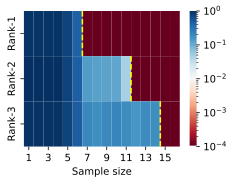

In [31]:
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
set_figsize((3.5, 2.5))
test_ls_array = np.array([list(test_ls_M1.values()), list(test_ls_M2.values()), list(test_ls_M3.values())])
test_ls_array
sns.heatmap(test_ls_array, cmap='RdBu', annot=False, norm=LogNorm(vmax=1e0, vmin=1e-4))
plt.vlines(6, 0, 1, colors='yellow', linestyles='dashed')
plt.vlines(11, 1, 2, colors='yellow', linestyles='dashed')
plt.vlines(14, 2, 3, colors='yellow', linestyles='dashed')
plt.xlabel('Sample size')
plt.xticks(np.array([0, 2, 4, 6, 8, 10, 12, 14])+0.5, [1, 3, 5, 7, 9, 11, 13, 15], rotation=0)
plt.yticks([0.5, 1.5, 2.5], ['Rank-1', 'Rank-2', 'Rank-3'])
plt.savefig('MF_optimistic.pdf', bbox_inches='tight')
plt.show()

## 神经网络实验

In [7]:
import tqdm
def train(net, train_iter, num_epochs, lr, device, test_iter=None):
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    timer, num_batches = Timer(), len(train_iter)
    train_ls, test_ls = [], []
    # train_accs, test_accs = [], []
    # bar = tqdm.tqdm(total = num_epochs)
    for epoch in range(num_epochs):
        metric = Accumulator(2)  
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[1]
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                # print(f'{i}, train_loss: {train_l}')
                train_ls.append(train_l)
        if train_ls[-1] < 1e-8:
            break
        net.eval()
        metric2 = Accumulator(2)
        if test_iter != None:
            with torch.no_grad():
                for (X_test,y_test) in test_iter:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    y_hat = net(X_test)
                    l = loss(y_hat, y_test)
                    metric2.add(l * X_test.shape[0], X_test.shape[0])
                test_l = metric2[0] / metric2[1]
                test_ls.append(test_l)
        # bar.set_description('Epoch:')
        # bar.update(1)
    if test_iter != None:
        print(f'train loss {train_l:.3f}', 
                f'test loss {test_l:.3f}')
    else:
        print(f'train loss {train_l:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return train_ls, test_ls

In [8]:
# 定义目标函数
def f_star(x, a = 1, w = 1, b = 1):
    y = a * torch.tanh(w * x + 1 * b)
    return y

def generate_data(a, w, b, num_samples):
    # x = torch.randn(num_samples, 2)
    # [-1, 1] uniform distribution
    x = 2 * torch.rand(num_samples, 1) - 1
    y = f_star(x, a, w, b)
    return x, y

sample_size = 2
x_train, y_train = generate_data(1.0, 1.0, 1.0, sample_size)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)

test_size = 1000
x_test, y_test = generate_data(1.0, 1.0, 1.0, test_size)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [9]:
# 神经网络模型，宽度为 2
num_inputs, num_outputs, num_hiddens = 1, 1, 2
loss = nn.MSELoss()
sigma = 1e-12 # 初始化参数的标准差
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(num_inputs, num_hiddens)
        self.activation = nn.Tanh()
        self.output = nn.Linear(num_hiddens, num_outputs, bias=False)

    def forward(self, x):
        return self.output(self.activation(self.hidden(x)))

batch_size, num_epochs, lr = 1024, 10000, 1e-1
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)
train_ls_dict_NN_2 = {}
test_ls_dict_NN_2 = {}
def init_weights(m, sigma=1e-12):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        # nn.init.xavier_uniform_(m.weight)
        nn.init.normal_(m.weight, 0, sigma)
        if m.bias is not None:
            nn.init.normal_(m.bias, 0, sigma)
for sample_size in range(1, 10):
    l = 0
    num_trails = 10
    for trail in range(num_trails):
        net = NeuralNetwork()
        net.apply(init_weights)
        x_train, y_train = generate_data(1.0, 1.0, 1.0, sample_size)
        train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
        train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
        train_ls_dict_NN_2[sample_size], _ = train(net, train_iter, num_epochs, lr, try_gpu(), test_iter=None)
        # compute the test loss
        net.eval()
        with torch.no_grad():
            x_test, y_test = x_test.to(try_gpu()), y_test.to(try_gpu())
            y_hat = net(x_test)
            l += loss(y_hat, y_test)
    test_ls_dict_NN_2[sample_size] = l / num_trails

training on cpu
train loss 0.000
54540.0 examples/sec on cpu
training on cpu
train loss 0.000
391745.7 examples/sec on cpu
training on cpu
train loss 0.000
425165.9 examples/sec on cpu
training on cpu
train loss 0.000
385495.3 examples/sec on cpu
training on cpu
train loss 0.000
289882.1 examples/sec on cpu
training on cpu
train loss 0.000
339930.8 examples/sec on cpu
training on cpu
train loss 0.000
355660.5 examples/sec on cpu
training on cpu
train loss 0.000
326921.4 examples/sec on cpu
training on cpu
train loss 0.000
391636.0 examples/sec on cpu
training on cpu
train loss 0.000
337398.7 examples/sec on cpu
training on cpu
train loss 0.000
472597.6 examples/sec on cpu
training on cpu
train loss 0.000
466606.7 examples/sec on cpu
training on cpu
train loss 0.000
431317.5 examples/sec on cpu
training on cpu
train loss 0.000
512675.9 examples/sec on cpu
training on cpu
train loss 0.000
415693.3 examples/sec on cpu
training on cpu
train loss 0.000
431044.9 examples/sec on cpu
training 

In [10]:
# 神经网络模型，宽度为 20
num_inputs, num_outputs, num_hiddens = 1, 1, 20
loss = nn.MSELoss()
sigma = 1e-12 # 初始化参数的标准差
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(num_inputs, num_hiddens)
        self.activation = nn.Tanh()
        self.output = nn.Linear(num_hiddens, num_outputs, bias=False)

    def forward(self, x):
        return self.output(self.activation(self.hidden(x)))

batch_size, num_epochs, lr = 1024, 10000, 1e-1
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)
train_ls_dict_NN_20 = {}
test_ls_dict_NN_20 = {}
def init_weights(m, sigma=1e-12):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        # nn.init.xavier_uniform_(m.weight)
        nn.init.normal_(m.weight, 0, sigma)
        if m.bias is not None:
            nn.init.normal_(m.bias, 0, sigma)
for sample_size in range(1, 10):
    l = 0
    num_trails = 10
    for trail in range(num_trails):
        net = NeuralNetwork()
        net.apply(init_weights)
        x_train, y_train = generate_data(1.0, 1.0, 1.0, sample_size)
        train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
        train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
        train_ls_dict_NN_20[sample_size], _ = train(net, train_iter, num_epochs, lr, try_gpu(), test_iter=None)
        # compute the test loss
        net.eval()
        with torch.no_grad():
            x_test, y_test = x_test.to(try_gpu()), y_test.to(try_gpu())
            y_hat = net(x_test)
            l += loss(y_hat, y_test)
    test_ls_dict_NN_20[sample_size] = l / num_trails

training on cpu
train loss 0.000
153747.9 examples/sec on cpu
training on cpu
train loss 0.000
218852.3 examples/sec on cpu
training on cpu
train loss 0.000
269560.3 examples/sec on cpu
training on cpu
train loss 0.000
307854.6 examples/sec on cpu
training on cpu
train loss 0.000
320171.0 examples/sec on cpu
training on cpu
train loss 0.000
422119.3 examples/sec on cpu
training on cpu
train loss 0.000
330888.1 examples/sec on cpu
training on cpu
train loss 0.000
304486.7 examples/sec on cpu
training on cpu
train loss 0.000
405948.8 examples/sec on cpu
training on cpu
train loss 0.000
285022.4 examples/sec on cpu
training on cpu
train loss 0.000
443973.2 examples/sec on cpu
training on cpu
train loss 0.000
443743.1 examples/sec on cpu
training on cpu
train loss 0.000
50594.3 examples/sec on cpu
training on cpu
train loss 0.000
222386.2 examples/sec on cpu
training on cpu
train loss 0.000
462952.6 examples/sec on cpu
training on cpu
train loss 0.000
460487.5 examples/sec on cpu
training 

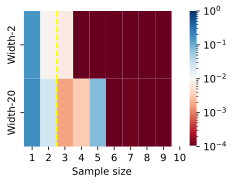

In [32]:
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
set_figsize((3.5, 2.5))
test_ls_array = np.array([list(test_ls_dict_NN_2.values()), list(test_ls_dict_NN_20.values())])
sns.heatmap(test_ls_array, cmap='RdBu', annot=False, norm=LogNorm(vmax=1e0, vmin=1e-4))
plt.vlines(2, 0, 1, colors='yellow', linestyles='dashed')
plt.vlines(2, 1, 2, colors='yellow', linestyles='dashed')
plt.xlabel('Sample size')
plt.xticks(np.arange(10)+0.5, range(1, 11), rotation=0)
plt.yticks([0.5, 1.5], ['Width-2', 'Width-20'])
plt.savefig('NN_optimistic.pdf', bbox_inches='tight')
# plt.savefig('name.svg', bbox_inches='tight')
plt.show()